<a href="https://colab.research.google.com/github/yjoonjang/text-mining/blob/main/3-2%E1%84%80%E1%85%A1.%20%E1%84%80%E1%85%A1%E1%86%B7%E1%84%89%E1%85%A5%E1%86%BC%20%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3-2. 감성 분석(Sentiment Analysis)
=====
올리브영 평점 분석
-----
이번에는 올리브영 평점 분류를 통해 감정 단어를 추출해보겠습니다.<br>
보통 영화 리뷰로 많이 감성 분석을 많이 하는데, 그보다는 조금 더 프로덕트 레벨에 가까운 케이스가 좋을 것 같아서 '올리브영'으로 선정하였습니다.

감성 분석은 결국 텍스트 분류의 문제입니다. 그 중에서도 긍정과 부정으로만 나뉘는 <b>이진 분류(Binary Classification)</b>입니다.<br>
이번에는 머신러닝 모델 중 하나인 Logistic Regression을 통해 학습시켜보고자 합니다.<br>
기본적인 프로세스는 다음과 같습니다.
- 데이터 전처리
- 텍스트 전처리
- TF-IDF 벡터화
- Logistic Regression 학습

In [1]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Seaborn 그래프 한글 폰트를 설치합니다.
# 설치 후 런타임을 다시 시작합니다.
# 상단 메뉴 '런타임' > '런타임 다시 시작'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,442 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and di

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# 데이터 불러오기
import os
path = '/content/drive/MyDrive/text-mining'
filename = '올리브영 상품 리뷰 평점_2022.08.23 (강의용).csv'
df = pd.read_csv(os.path.join(path, filename))

In [5]:
# 데이터 정보 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36091 entries, 0 to 36090
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       36091 non-null  int64 
 1   작성자ID    36091 non-null  int64 
 2   작성자피부타입  36091 non-null  object
 3   상품명      36091 non-null  object
 4   상품옵션     36091 non-null  object
 5   리뷰       36091 non-null  object
 6   리뷰도움     36091 non-null  int64 
 7   평점       36091 non-null  int64 
 8   리뷰_전처리   36091 non-null  object
 9   리뷰_명사    36049 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.8+ MB


In [6]:
# 데이터 확인하기
df.head()

,ID,작성자ID,작성자피부타입,상품명,상품옵션,리뷰,리뷰도움,평점,리뷰_전처리,리뷰_명사
0,0,3925,복합성 겨울쿨톤 각질 잡티,[클리어런스] 클리오 멜팅 쉬어 글로우 밤,[옵션] 001 핑크,새로 나온 제품이라서 리뷰도 없었는데 좋을 것 같아서 사봤습니다 매일매일 바르고 다...,9,4,새롭다 나오다 제품 이라서 리뷰 도 없다 좋다 것 같다 사보다 매 일 매일 바르다 ...,제품 리뷰 것 매일 립밤 멜팅 글 로우 밤 외관 핑크색 입술 기도 제 맑은 광채 거...
1,1,71,복합성 웜톤 각질 모공,[클리어런스] 클리오 멜팅 쉬어 글로우 밤,[옵션] 003 로지,멜팅 쉬어 글로우 밤 이라는 이름에 끌려서 주문했어요.음.. 근데 글로우 ᅲᅲ 넘 ...,2,4,멜팅 쉬다 글 로우 밤 이라는 이름 에 끌리다 주문 하다 . 음 .. 근데 글 로우...,멜팅 글 로우 밤 이름 주문 음 글 로우 글 로우 안 일반 립밤 정도 칼라 거의 안...
2,2,3838,복합성 웜톤 주름 탄력,[클리어런스] 클리오 멜팅 쉬어 글로우 밤,[옵션] 002 코랄,처음에 구매했던 핑크 립밤이 너무 마음에 들어 이번에는 다른 색으로 써 보고 싶어 ...,2,4,처음 에 구매 하다 핑크 립밤 이 너무 마음 에 들다 이번 에는 다른 색 으로 써다...,처음 구매 핑크 립밤 마음 이번 다른 색 보고 코랄 구매 핑크 발색 조금 더 편이 ...
3,3,4285,지성 쿨톤 각질 블랙헤드,[클리어런스] 클리오 멜팅 쉬어 글로우 밤,[옵션] 001 핑크,"얼마전에 군 입대(여군)로 립밤을 들고가야 했는데 , 색 있는 립밤은 안되고 , 니...",8,5,"얼마 전 에 군 입대 ( 여군 ) 로 립밤 을 들다 하다 , 색 있다 립밤 은 안되...",얼마 전 군 입대 여군 로 립밤 색 립밤 니베아 딸기 색 정도 립밤 구매 처음 디올...
4,4,3838,복합성 웜톤 주름 탄력,[클리어런스] 클리오 멜팅 쉬어 글로우 밤,[옵션] 001 핑크,정말 촉촉하게 잘 발리는 립밤을 찾은 것 같아 좋아요! 제가 술이 금방 건조해지고 ...,2,5,정말 촉촉하다 자다 발리다 립밤 을 찾다 것 같다 좋다 ! 제 가 술 이 금방 건조...,정말 립밤 것 제 술 금방 립밤 상시 가지 사람 립밤 구매 제품 다른 일반 립밤 조...


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


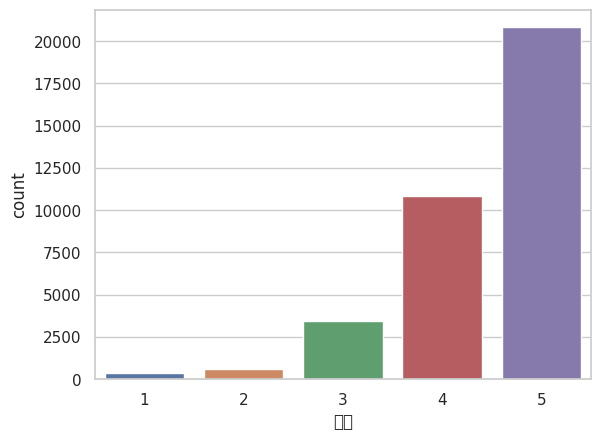

In [9]:
# 평점 별 개수 확인
sns.set_theme(font ='NanumGothic',
        	rc = {'axes.unicode_minus' : False},
        	style ='whitegrid')

# Countplot
sns.countplot(data = df, x = '평점')
plt.show()

In [11]:
# 감정 라벨링
df['label'] = df['평점'].map(lambda x : 1 if x > 3 else 0)

In [12]:
# KoNLPy 설치
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 47.7 MB/s eta 0:00:00


### 형태소 기준 전처리

In [ ]:
# # 리뷰 전처리 (약 20분 소요)
# df['리뷰_전처리'] = df['리뷰'].map(lambda x: okt.morphs(x, stem = True)).map(lambda x: ' '.join(x))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
# 데이터 스플릿(훈련 데이터와 테스트 데이터)
train_text, test_text, train_label, test_label = train_test_split(df['리뷰_전처리'], df['label'], test_size = 0.3, random_state = 0)

In [19]:
# train_text 확인
train_text

12674    루나 포토 피다 쓰다 힛팬해 서 새롭다 사다 . 피부 는 건성 인데 메이크업 후 에...
12614    ✅ 20 대다 후반 인 동생 에게 선물 로 준 제품 이다 . 물론 본인 이 강하다 ...
31203    바비 의 스틱 섀도우 는 챡챡챡 모으다 템 이다 . 가지 고 다니다 넘다 편하다 평...
3354     여 쿨 트루 추천 제품 이라 사보다 확실하다 바르다 얼굴 이 화사하다 보이다 하다 ...
25303    저 이 거 너무 좋다 ♡♡ 원래 아이라인 머 지 거 사용 하다 어느 날 친구 가 아...
                               ...                        
20757    이전 에 주황색 치약 마스카라 써다 엄마 와 저 모두 너무 만족하다 . 그래서 이번...
32103    머리 를 염색 하고 나서다 눈썹 이 너무 동동 뜨다 것 같다 아이브 로우 마스카라 ...
30403    🍂 가을 웜톤 인데 밝다 피부 그러나 다크 써클 ( 갈색 계열 ) 이 눈 을 중심 ...
21243    브라운 마스카라 가 필요하다 구매 를 하다 . 첫날 써다 땐 자다 모르다 날 이 갈...
2732     “ 글 로시 립 중 에 제일 맘 에 들다 ..: ᅲᅲ” 봄웜 라 주목 💥💥💥 글 로...
Name: 리뷰_전처리, Length: 25263, dtype: object

In [20]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(min_df = 1, norm = 'l2', ngram_range=(1,1))

In [21]:
train_features = vectorizer.fit_transform(train_text)

In [23]:
# LogisticRegression
model = LogisticRegression(C = 0.1)

In [25]:
# LogisticRegression 모델에 훈련 데이터 학습
model.fit(train_features, train_label)

LogisticRegression(C=0.1)

In [26]:
# 테스트 데이터 벡터화
test_features = vectorizer.transform(test_text)

In [27]:
# 훈련시킨 모델로 테스트 데이터 예측
model.predict(test_features)

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
# 정확도 테스트
pred_labels = model.predict(test_features)
print('잘못 분류된 리뷰: {} out of {}'.format((pred_labels != test_label).sum(),len(test_label)))
print('Accuracy: %.2f' % accuracy_score(test_label, pred_labels))

잘못 분류된 리뷰: 1316 out of 10828
Accuracy: 0.88


In [30]:
vectorizer.vocabulary_.items()

dict_items([('루나', 7764), ('포토', 24090), ('피다', 24405), ('쓰다', 14623), ('힛팬해', 26128), ('새롭다', 12510), ('사다', 12068), ('피부', 24417), ('건성', 2610), ('인데', 18513), ('메이크업', 8691), ('마스크', 8137), ('묻다', 9243), ('싫다', 14386), ('얹히다', 15804), ('있다', 18843), ('느낌', 5300), ('파우더', 23448), ('처리', 21304), ('하다', 24729), ('예전', 16519), ('에는', 16008), ('타입', 22717), ('많이', 8333), ('나오다', 4519), ('팩트', 23586), ('형태', 25438), ('되다', 6424), ('밖에', 9850), ('제품', 19874), ('사보다', 12117), ('되어다', 6436), ('아직', 14940), ('사용', 12155), ('해보다', 25090), ('뚜껑', 7132), ('자마자', 18962), ('우르르', 17179), ('쏟아지다', 14603), ('와르르', 16837), ('멘탈', 8717), ('이다', 18149), ('ᅲᅲ', 1785), ('브러쉬', 11340), ('리뷰', 7872), ('보고', 10604), ('고급', 2939), ('지다', 20505), ('기대하다', 3909), ('들어가다', 6714), ('비슷하다', 11592), ('짧다', 20822), ('뚱하다', 7160), ('코팅', 22243), ('이라', 18175), ('파운데이션', 23451), ('같다', 2330), ('부디', 10960), ('끼임', 4424), ('없이', 15946), ('자다', 18944), ('밀착', 9643), ('좋다', 20117), ('20', 184), ('대다', 5767), ('후반', 2581

In [29]:
# 사용된 단어 리스트
vocablist = [word for word, _ in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])]

In [31]:
model.coef_.tolist()

[[0.00931972032325839,
  0.009131343313664915,
  0.030744160534266488,
  0.002211548150401389,
  0.0018339575932194083,
  0.03061407477538619,
  0.0018431571139852455,
  -0.012160147354365212,
  0.0018431571139852455,
  0.021347701418431158,
  0.014483929737448692,
  0.0018431571139852455,
  0.014487866347500211,
  0.002213229093819262,
  0.005046614604197112,
  0.0011400605042181876,
  0.06804431486234946,
  0.012103440668227699,
  0.001705184014202868,
  0.0010691778942162858,
  -0.05485384602953931,
  -0.02747303727862147,
  0.004137734188963164,
  0.0017318630811655033,
  0.01247532186389456,
  0.07060456789906613,
  0.0070422052513831575,
  0.0028770382094597522,
  0.0018154483192332578,
  0.004369755136877045,
  0.002619082862924316,
  0.0007132476095502943,
  0.054380484726746246,
  0.01246160599947824,
  0.011243030745913417,
  0.002361965641080875,
  0.04378626988233036,
  0.003973228489703109,
  0.0007132476095502943,
  0.03604305899976716,
  0.0019599855976476076,
  0.001356

In [32]:
# 가중치 계산
coefficients = model.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# 학습에 사용된 각 단어마다의 coefficient (즉 weight) 값이 존재

In [33]:
# 긍정단어 TOP 50
for word, coef in sorted_coefficients[:50]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))

좋다 (2.262)
ᄒᄒ (1.469)
있다 (1.369)
만족하다 (1.094)
진짜 (1.071)
예쁘다 (1.068)
사용 (0.977)
되다 (0.930)
없이 (0.907)
해주다 (0.811)
까지 (0.802)
최고 (0.786)
고민 (0.764)
마음 (0.756)
레드 (0.747)
들다 (0.745)
이쁘다 (0.743)
컬러 (0.741)
만족스럽다 (0.739)
촉촉하다 (0.728)
일리 (0.727)
자연 (0.726)
부드럽다 (0.715)
스럽게 (0.715)
찰떡 (0.707)
메이크업 (0.687)
아주 (0.684)
으로 (0.673)
섀도우 (0.667)
파운데이션 (0.667)
편하다 (0.666)
살짝 (0.657)
완전 (0.654)
추천 (0.653)
만족 (0.638)
선물 (0.633)
하다 (0.622)
에도 (0.620)
이에요 (0.619)
피부 (0.606)
블러셔 (0.591)
넘다 (0.590)
브라운 (0.588)
색도 (0.580)
타입 (0.567)
화장 (0.563)
같이 (0.559)
정착 (0.557)
립스틱 (0.552)
부담 (0.551)


In [34]:
# 부정단어 TOP 50
for word, coef in sorted_coefficients[-50:]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))

다시 (-0.404)
나쁘다 (-0.414)
짧다 (-0.425)
다시다 (-0.430)
손등 (-0.431)
최악 (-0.441)
애매하다 (-0.443)
아쉬움 (-0.449)
공홈 (-0.451)
뭉치다 (-0.458)
에게는 (-0.459)
버리다 (-0.465)
스럽다 (-0.467)
문제 (-0.491)
아니다 (-0.502)
재다 (-0.506)
배송 (-0.510)
아깝다 (-0.511)
이상하다 (-0.554)
나다 (-0.559)
어렵다 (-0.568)
성은 (-0.599)
맞다 (-0.609)
심해 (-0.620)
차라리 (-0.627)
비추다 (-0.630)
그렇다 (-0.647)
사다 (-0.659)
심하다 (-0.678)
안좋다 (-0.707)
입술 (-0.735)
그나마 (-0.742)
발색 (-0.753)
약하다 (-0.790)
부러지다 (-0.803)
ᅮᅮ (-0.819)
많이 (-0.854)
실망하다 (-0.970)
생각 (-0.976)
매다 (-1.030)
건지다 (-1.037)
기대 (-1.041)
안되다 (-1.127)
기대하다 (-1.247)
실망 (-1.356)
모르다 (-1.528)
그냥 (-1.691)
별로 (-1.954)
ᅲᅲ (-2.093)
아쉽다 (-2.202)


### 명사 기준 전처리

In [35]:
# # 리뷰 전처리
# df['리뷰_명사'] = df['리뷰'].map(lambda x: okt.nouns(x)).map(lambda x: ' '.join(x))

In [36]:
# 데이터 스플릿(훈련 데이터와 테스트 데이터)
train_texts, test_texts, train_labels, test_labels = train_test_split(df.dropna(subset = '리뷰_명사')['리뷰_명사'], df.dropna(subset = '리뷰_명사')['label'], test_size=0.3, random_state=0)

In [37]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(min_df=1, norm='l2', ngram_range=(1,1))
train_features = vectorizer.fit_transform(train_texts)

In [38]:
# LogisticRegression 모델에 훈련 데이터 학습
model.fit(train_features, train_labels)

LogisticRegression(C=0.1)

In [39]:
# 테스트 데이터 벡터화
test_features = vectorizer.transform(test_texts)

In [40]:
# 훈련시킨 모델로 테스트 데이터 예측
model.predict(test_features)

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
# 정확도 테스트
pred_labels = model.predict(test_features)
print('잘못 분류된 리뷰: {} out of {}'.format((pred_labels != test_labels).sum(),len(test_labels)))
print('Accuracy: %.2f' % accuracy_score(test_labels, pred_labels))

잘못 분류된 리뷰: 1305 out of 10815
Accuracy: 0.88


In [42]:
# 사용된 단어
vocablist = [word for word, _ in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])]

In [43]:
# 가중치 계산
coefficients = model.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# 학습에 사용된 각 단어마다의 coefficient (즉 weight) 값이 존재

In [44]:
# 긍정단어 TOP 50
for word, coef in sorted_coefficients[:50]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))

사용 (1.255)
자연 (1.158)
진짜 (1.108)
아주 (0.979)
일리 (0.950)
고민 (0.911)
마음 (0.905)
최고 (0.898)
만족 (0.821)
선물 (0.801)
메이크업 (0.781)
블러셔 (0.772)
쿠션 (0.767)
추천 (0.744)
부담 (0.739)
찰떡 (0.737)
피부 (0.730)
살짝 (0.708)
정착 (0.703)
브라운 (0.695)
립스틱 (0.691)
색도 (0.681)
요즘 (0.664)
컬러 (0.659)
표현 (0.650)
파운데이션 (0.644)
레드 (0.636)
화장 (0.629)
완전 (0.627)
이번 (0.619)
색상 (0.616)
편이 (0.601)
섀도우 (0.601)
글리터 (0.600)
걱정 (0.600)
계속 (0.595)
포인트 (0.593)
코랄 (0.592)
얼굴 (0.587)
정도 (0.572)
바비 (0.555)
역시 (0.538)
하나 (0.537)
아침 (0.529)
아이라이너 (0.525)
성도 (0.522)
가격 (0.521)
키스미 (0.512)
타입 (0.509)
유지 (0.508)


In [45]:
# 부정단어 TOP 50
for word, coef in sorted_coefficients[-50:]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))

인지 (-0.304)
페리페라 (-0.310)
기름 (-0.328)
성분 (-0.331)
부분 (-0.332)
분명 (-0.342)
그게 (-0.348)
리뷰 (-0.350)
달라 (-0.352)
색력 (-0.359)
안나 (-0.364)
제대로 (-0.365)
자체 (-0.370)
난리 (-0.372)
뻑뻑 (-0.372)
런가 (-0.372)
후회 (-0.378)
롬앤 (-0.382)
뭔가 (-0.402)
의사 (-0.406)
각질 (-0.409)
별루 (-0.422)
당황 (-0.426)
배송 (-0.449)
개인 (-0.449)
잘못 (-0.459)
사지 (-0.460)
최악 (-0.471)
발림 (-0.488)
절대 (-0.489)
손등 (-0.493)
냄새 (-0.496)
건가 (-0.502)
문제 (-0.535)
아쉬움 (-0.558)
다시 (-0.595)
공홈 (-0.638)
교환 (-0.658)
발색 (-0.668)
다소 (-0.684)
그닥 (-0.695)
입술 (-0.740)
성은 (-0.751)
차라리 (-0.761)
심해 (-0.821)
기대 (-1.213)
생각 (-1.244)
실망 (-1.691)
그냥 (-1.738)
별로 (-2.425)
